In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import time
from sklearn.preprocessing import StandardScaler

In [2]:
import utils

# Read data

In [3]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [4]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [6]:
object_ids = np.unique(data.object_id)

In [7]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

In [8]:
ss = StandardScaler()

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject_new = anobject.copy()
    anobject_new.loc[:, 'log_lam'] = np.array(log_lam)
    return anobject_new

In [12]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [13]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [14]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    plt.show()

In [15]:
def scaler_transform(anobject):
    X = ss.fit_transform(anobject[['mjd', 'log_lam']].values)
    y = anobject['flux'].values
    return X, y

In [16]:
def compile_obj(t, flux, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['passband'] = passband
    return obj

In [17]:
def array_exp_parabol23(anobject_train):
    anobject_train_lin        = anobject_train.copy()
    anobject_train_exp_x      = anobject_train.copy()
    anobject_train_exp_y      = anobject_train.copy()
    anobject_train_2_parabola = anobject_train.copy()
    anobject_train_3_parabola = anobject_train.copy()
    
    anobject_train_exp_x['mjd']      = np.log(anobject_train_exp_x['mjd'])
    anobject_train_exp_y['flux']     = np.log(anobject_train_exp_y['mjd'])
    anobject_train_2_parabola['mjd'] = anobject_train_2_parabola['mjd'].values ** 2
    anobject_train_3_parabola['mjd'] = anobject_train_2_parabola['mjd'].values ** 3
    
    return anobject_train_lin, anobject_train_exp_x, anobject_train_exp_y, anobject_train_2_parabola, anobject_train_3_parabola

In [18]:
def flux_not_negativ(anobject):
    anobject_new = anobject.copy()
    anobject_new['flux'] = np.where(anobject_new['flux'] < 0, 0, anobject_new['flux'])
    return anobject_new

34299


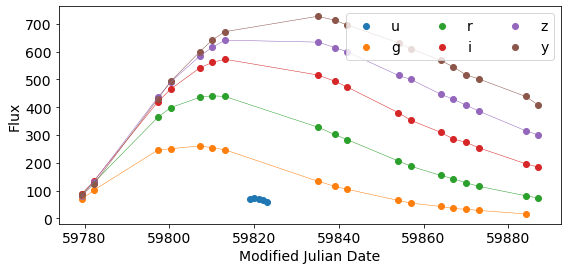

43812


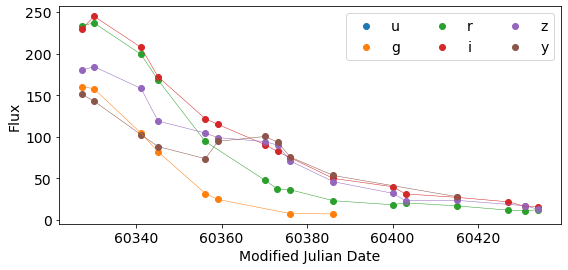

70046


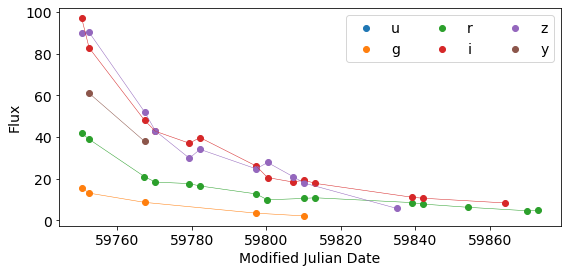

84716


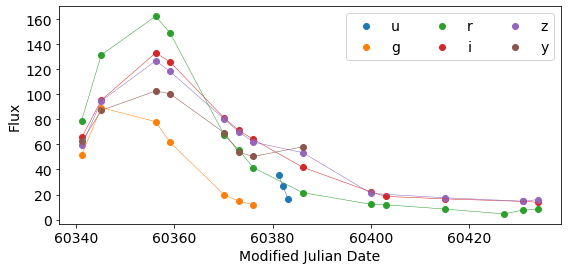

131629


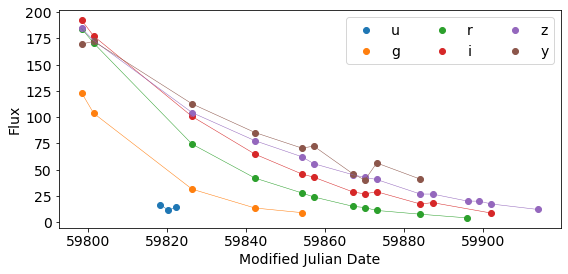

169315


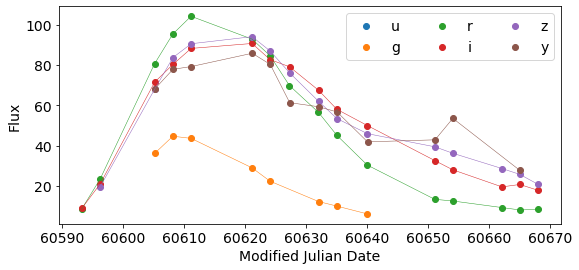

229855


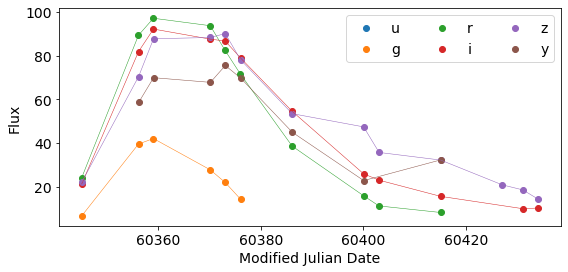

251430


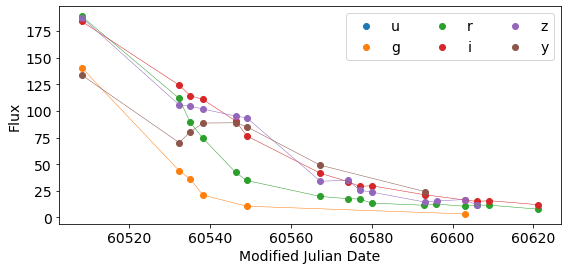

282714


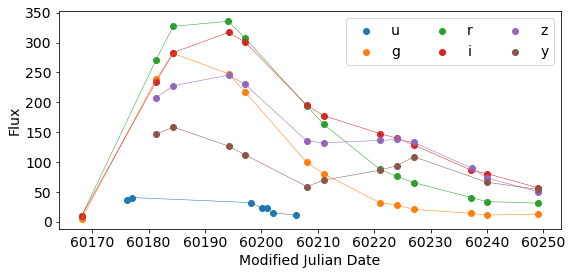

290682


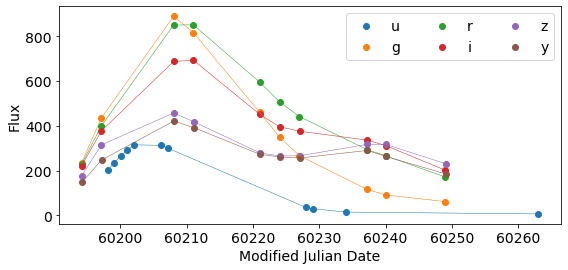

316306


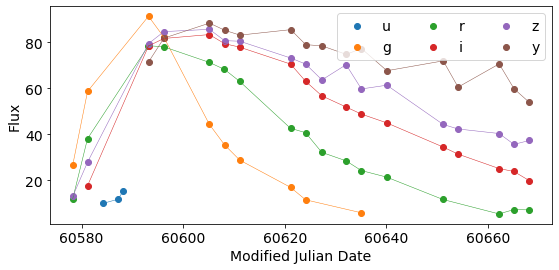

In [19]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

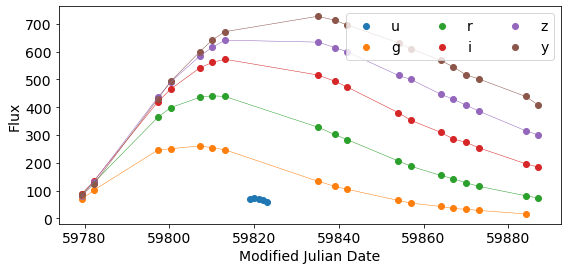

In [20]:
anobject = get_object(data, 34299)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [23]:
anobject_trains = array_exp_parabol23(anobject_train)

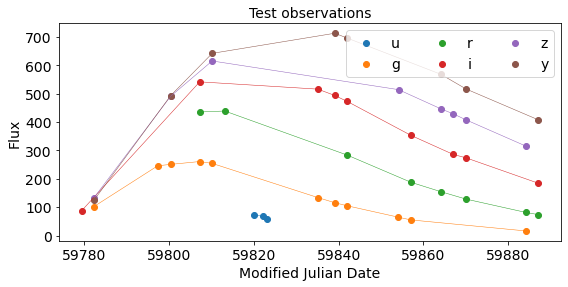

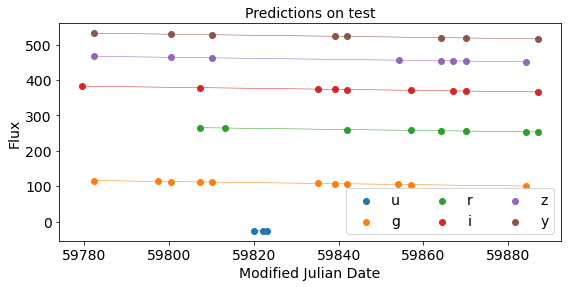

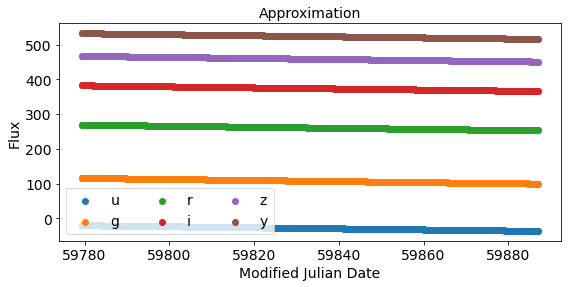

RMSE:  138.29307470190685
MAE:  109.52206779638875
RSE:  0.6980275226017059
RAE:  0.6254334507442167
MAPE:  74.5003849575725
Work sec: 1.524567
--------------------------------------


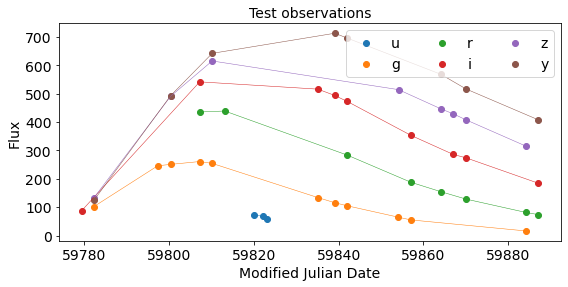

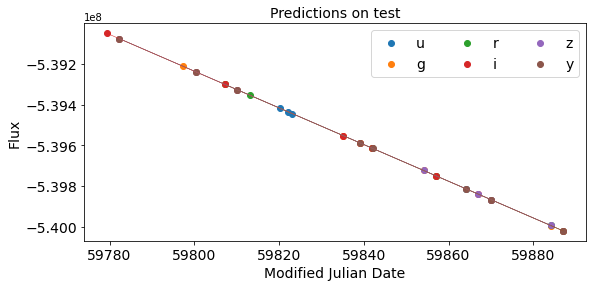

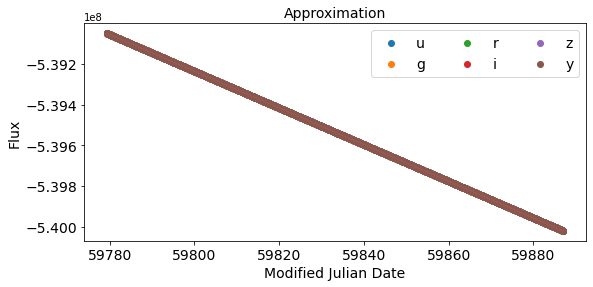

RMSE:  539583691.9536294
MAE:  539583614.3809981
RSE:  2723522.262720221
RAE:  3081330.079840511
MAPE:  372409675.46665114
Work sec: 0.916839
--------------------------------------


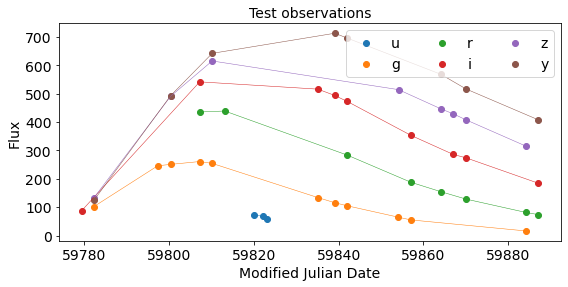

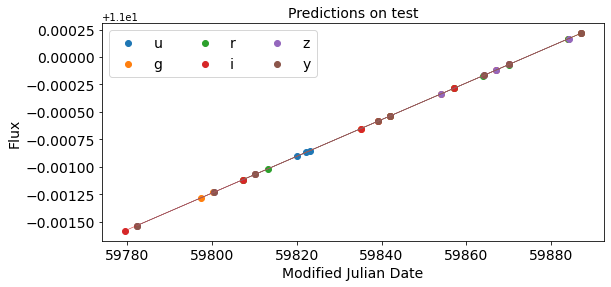

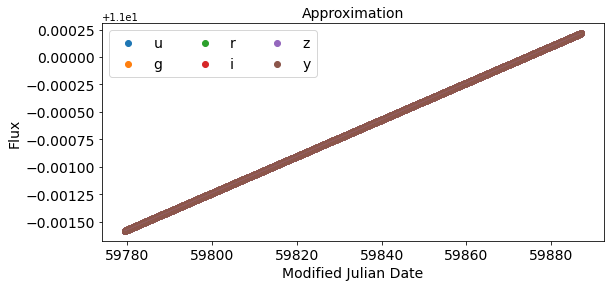

RMSE:  354.0900695879253
MAE:  293.4762569061978
RSE:  1.7872522871090457
RAE:  1.6759167514036994
MAPE:  92.40929584271507
Work sec: 1.259442
--------------------------------------


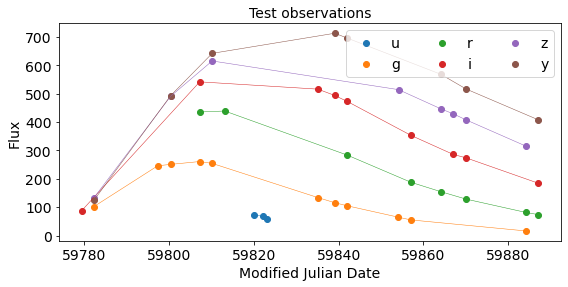

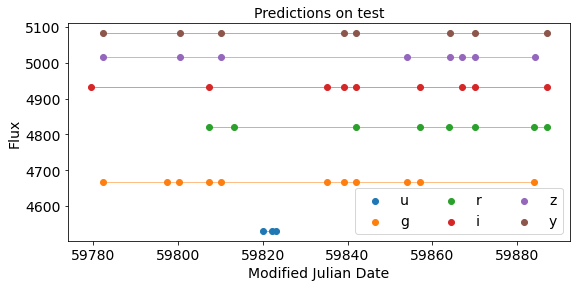

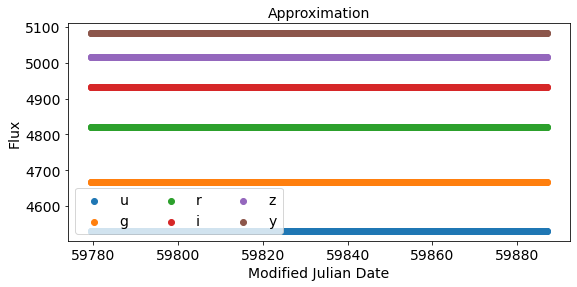

RMSE:  4563.1707629025495
MAE:  4561.043068524162
RSE:  23.032380975715505
RAE:  26.046156384148517
MAPE:  3179.853576135159
Work sec: 1.511838
--------------------------------------


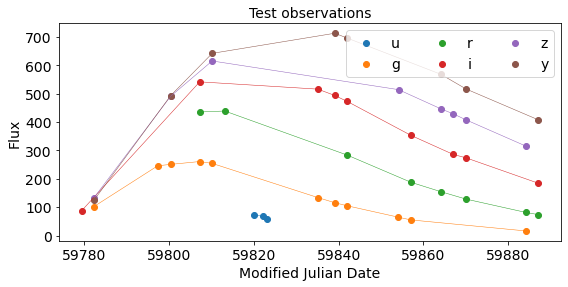

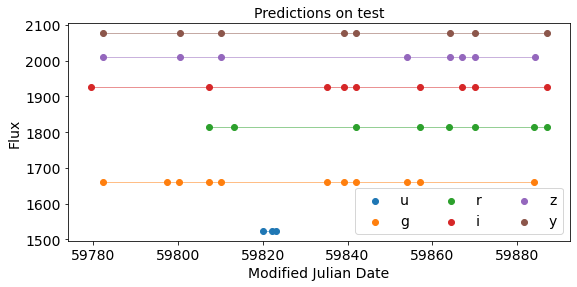

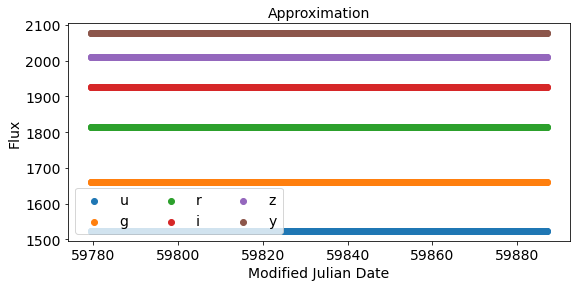

RMSE:  1561.006529468096
MAE:  1554.7757459266738
RSE:  7.879104017886715
RAE:  8.878655959236703
MAPE:  1105.2461397868158
Work sec: 1.291278
--------------------------------------


In [24]:
import LR_aug
# flux = a + b * mjd
for anobject_train in anobject_trains:
    timer = time.time()
    anobject_train = flux_not_negativ(anobject_train)
    model = LR_aug.LinearRegressionAugmentation(passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

    t_aug, flux_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                     anobject['mjd'].max(), n_obs=1000)

    anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                     anobject_test['passband'].values)
    anobject_aug = compile_obj(t_aug, flux_aug, passband_aug)

    plot_light_curves(anobject_test, "Test observations")
    plot_light_curves(anobject_test_pred, "Predictions on test")
    plot_light_curves(anobject_aug, "Approximation")

    [rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                          anobject_test_pred['flux'].values)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("RSE: ", rse)
    print("RAE: ", rae)
    print("MAPE: ", mape)
    print("Work sec: %f" % (time.time() - timer))
    print("--------------------------------------")

# Test on many objects

In [25]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids: 
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if not is_good(anobject): continue
    
    print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    model = LR_aug.LinearRegressionAugmentation(passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

    t_aug, flux_aug, passband_aug = model.augmentation(anobject['mjd'].min(), anobject['mjd'].max(), n_obs=1000)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, flux_pred)
    report.loc[len(report), :] = [i] + list(metrics)
    

Object  745  with  61  observations
Object  1124  with  61  observations
Object  1920  with  55  observations
Object  2922  with  58  observations
Object  4173  with  77  observations
Object  4389  with  58  observations
Object  4819  with  73  observations
Object  6180  with  55  observations
Object  7033  with  72  observations
Object  7164  with  59  observations
Object  10321  with  106  observations
Object  10757  with  62  observations
Object  11359  with  80  observations
Object  11507  with  66  observations
Object  13079  with  71  observations
Object  13138  with  99  observations
Object  13194  with  61  observations
Object  13459  with  47  observations
Object  14279  with  74  observations
Object  14674  with  62  observations
Object  15002  with  58  observations
Object  15674  with  74  observations
Object  15845  with  75  observations
Object  15968  with  42  observations
Object  17370  with  90  observations
Object  18029  with  59  observations
Object  18556  with  9

In [26]:
np.round(report.mean(), 2)

ID      340898.23
RMSE        79.97
MAE         59.86
RSE          0.65
RAE          0.61
MAPE        93.60
dtype: float64

In [27]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,33.2123,23.4542,0.634469,0.63429,106.816
1,1124,22.9841,17.1498,0.618141,0.640721,108.934
2,1920,54.7738,36.2976,0.88553,0.726119,123.59
3,2922,65.0559,55.7476,0.940162,1.5838,256.318
4,4173,24.5409,18.1828,0.494943,0.443084,80.849
...,...,...,...,...,...,...
511,339169,12.9032,9.08082,0.867124,0.702859,53.909
512,341653,20.2933,15.675,0.680491,0.619205,59.4751
513,342659,20.8815,14.5757,0.614524,0.523553,52.223
514,8366012,89.7613,65.3593,0.735963,0.593528,123.505
